In [4]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# === SETUP ===
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download NLTK data 
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/umang1607/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/umang1607/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# === FILE PATHS ===
ehr_path = "/Users/umang1607/Desktop/Mimic_modeling/combined_diseases.xlsx"  # <-- our main file
sym2d_path = "/Users/umang1607/Desktop/Mimic_modeling/Symptom2Disease.csv"  # uploaded
sym_train_path = "/Users/umang1607/Desktop/Mimic_modeling/symptom-disease-train-dataset.csv"  # uploaded
mapping_path = "/Users/umang1607/Desktop/Mimic_modeling/mapping.json"  # uploaded

# === TARGET DISEASES (normalize to canonical names) ===
# our list: psoriasis, pneumonia, hemorrhoid, arthritis, asthma, jaundice,
#            urinary tract, peptic ulcer, diabetes, hypertension
canon_map = {
    "psoriasis": "Psoriasis",
    "pneumonia": "Pneumonia",
    "hemorrhoid": "Dimorphic Hemorrhoids",
    "arthritis": "Arthritis",
    "asthma": "Bronchial Asthma",
    "jaundice": "Jaundice",
    "urinary tract": "Urinary Tract Infection",
    "peptic ulcer": "Peptic Ulcer Disease",
    "diabetes": "Diabetes",
    "hypertension": "Hypertension",
    "heart failure": "Heart Failure",
    "kidney failure": "Kidney Failure"
}

target_diseases = list(canon_map.values())

In [3]:
# === 1) LOAD MAIN EHR FILE ===
df_ehr = pd.read_excel(ehr_path)
missing_cols = {'subject_id','gender','age','hadm_id','diagnosis_name','procedures','medications','lab_test','lab_value','valueuom','lab_time','note_text','note_time'} - set(df_ehr.columns)
if missing_cols:
    print("WARNING: EHR file is missing columns:", missing_cols)

# Standardize diagnosis_name to canonical forms where possible
def normalize_dx(name: str):
    if pd.isna(name):
        return name
    s = str(name).strip().lower()
    for k, v in canon_map.items():
        if k in s:
            return v
    return str(name).strip()

df_ehr['diagnosis_name'] = df_ehr['diagnosis_name'].apply(normalize_dx)

# Keep only our 10 diseases
df_ehr = df_ehr[df_ehr['diagnosis_name'].isin(target_diseases)].copy()
df_ehr['note_text'] = df_ehr['note_text'].fillna("")

In [4]:
# === 2) LOAD & FILTER Symptom2Disease.csv (label, text) ===
sym2d = pd.read_csv(sym2d_path)
# Standardize labels
sym2d['label'] = sym2d['label'].astype(str).str.strip()
sym2d['label_norm'] = sym2d['label'].str.lower().map({k: v for k, v in canon_map.items()})
# Some labels may already be canonical-cased; try a fallback
sym2d.loc[sym2d['label_norm'].isna(), 'label_norm'] = sym2d.loc[sym2d['label_norm'].isna(), 'label'].apply(
    lambda x: canon_map.get(x.lower(), x)
)
sym2d = sym2d[sym2d['label_norm'].isin(target_diseases)].rename(columns={'label_norm':'disease'})
sym2d = sym2d[['disease','text']].copy()

In [5]:
# === 3) LOAD & FILTER symptom-disease-train-dataset.csv (+ mapping.json) ===
with open(mapping_path, 'r') as f:
    name_to_id = json.load(f)  # keys are disease names, vals are ints
# invert: id -> name
id_to_name = {v:k for k, v in name_to_id.items()}

sym_train = pd.read_csv(sym_train_path)
# sym_train columns: text,label   (label is numeric)
# map numeric -> disease name string
sym_train['disease_name'] = sym_train['label'].map(id_to_name).astype(str)

# normalize to our canonical names
def map_to_canon(name):
    low = name.strip().lower()
    # exact match or contains
    for k, v in canon_map.items():
        if k in low:
            return v
            
sym_train['disease'] = sym_train['disease_name'].apply(map_to_canon)
sym_train = sym_train[sym_train['disease'].isin(target_diseases)].copy()

# Convert comma-separated symptom tokens into single text
def comma_list_to_text(s):
    if pd.isna(s):
        return ""
    return " ".join([t.strip().replace("_"," ") for t in str(s).split(",") if t.strip()])

sym_train['text'] = sym_train['text'].apply(comma_list_to_text)
sym_train = sym_train[['disease','text']].copy()

In [6]:
# === 4) Build a per-disease SYMPTOM CORPUS (from both sources) ===
corpus_from_sym2d = sym2d.groupby('disease')['text'].apply(lambda x: " ".join(map(str, x))).to_dict()
corpus_from_symtrain = sym_train.groupby('disease')['text'].apply(lambda x: " ".join(map(str, x))).to_dict()

# merge corpora
disease_corpus = {d: "" for d in target_diseases}
for d in target_diseases:
    d_texts = []
    if d in corpus_from_sym2d:
        d_texts.append(corpus_from_sym2d[d])
    if d in corpus_from_symtrain:
        d_texts.append(corpus_from_symtrain[d])
    disease_corpus[d] = " ".join(d_texts).strip()

# Build dictionary of disease -> list of symptom sentences from sym2d
disease_sym_map = sym2d.groupby("disease")["text"].apply(list).to_dict()

# If a disease has fewer symptom sentences (e.g., only 50 for hundreds of patients),
# we’ll sample with replacement — ensures every patient gets one symptom.
def random_symptom(disease):
    disease = str(disease).strip()
    if disease in disease_sym_map:
        return np.random.choice(disease_sym_map[disease], replace=True)
    return ""

# Assign each patient a random symptom description for their disease
df_ehr["symptom_text"] = df_ehr["diagnosis_name"].apply(random_symptom)

# Combine with existing note_text to create a richer textual feature
df_ehr["note_text"] = df_ehr["note_text"].fillna("")
df_ehr["symptom_text"] = df_ehr["symptom_text"].fillna("")
df_ehr["text_all"] = (df_ehr["note_text"].astype(str) + " " + df_ehr["symptom_text"].astype(str)).str.strip()

print("✅ Randomized symptom text assigned per patient.")
print(df_ehr[["diagnosis_name", "symptom_text"]].head(10))

✅ Randomized symptom text assigned per patient.
  diagnosis_name                                       symptom_text
0      Psoriasis  My skin is prone to infections due to dry, fla...
1      Psoriasis  I have noticed a sudden peeling of skin at dif...
2      Psoriasis  My skin has been peeling, especially on my kne...
3      Psoriasis  My nails are starting to have small pits on th...
4      Psoriasis  I am worried about the constant peeling of the...
5      Psoriasis  There is strange pain in my joints. Also, I ha...
6      Psoriasis  The skin around my mouth, nose, and eyes is re...
7      Psoriasis  There is a silver like dusting on my skin. Mor...
8      Psoriasis  My skin is extremely sensitive and quickly irr...
9      Psoriasis  I'm having joint discomfort in my fingers, wri...


In [7]:
df_ehr

,subject_id,gender,age,hadm_id,diagnosis_name,procedures,medications,lab_test,lab_value,valueuom,lab_time,note_text,note_time,original_disease,symptom_text,text_all
0,10004720,M,61,22081550,Psoriasis,"Respiratory Ventilation, Greater than 96 Conse...","CefePIME, Vancomycin, CefTAZidime, Propofol, V...",Sodium,134.0,mEq/L,2186-11-13 07:32:00,ADDENDUM There is a small to moderate right a...,2186-11-12 18:18:00,"Psoriasis, unspecified","My skin is prone to infections due to dry, fla...",ADDENDUM There is a small to moderate right a...
1,10007920,M,52,22218665,Psoriasis,NaN,"Docusate Sodium (Liquid), Emtricitabine-Tenofo...",Urea Nitrogen,11.0,mg/dL,2138-12-06 04:27:00,INDICATION: History: ___ with hypotension\n\n...,2138-12-04 09:36:00,Other psoriasis,I have noticed a sudden peeling of skin at dif...,INDICATION: History: ___ with hypotension\n\n...
2,10022041,M,64,28909879,Psoriasis,Open reduction of fracture with internal fixat...,"Glucagon, Calcium Carbonate, Gabapentin, D5 1/...",Glucose,99.0,mg/dL,2187-05-18 21:00:00,CHEST RADIOGRAPH\n\nINDICATION: Status post h...,2187-05-21 13:08:00,Other psoriasis,"My skin has been peeling, especially on my kne...",CHEST RADIOGRAPH\n\nINDICATION: Status post h...
3,10022041,M,64,28909879,Psoriasis,Open reduction of fracture with internal fixat...,"Glucagon, Calcium Carbonate, Gabapentin, D5 1/...",Sodium,136.0,mEq/L,2187-05-21 17:45:00,"HISTORY: Prior atelectasis, to assess for pne...",2187-05-23 07:21:00,Other psoriasis,My nails are starting to have small pits on th...,"HISTORY: Prior atelectasis, to assess for pne..."
4,10042769,M,91,25990801,Psoriasis,Percutaneous abdominal drainage,"Morphine Sulfate, Lidocaine 1%, Potassium Chlo...",Creatinine,1.4,mg/dL,2156-07-28 06:14:00,INDICATION: ___ year old man with right hip p...,2156-07-25 02:19:00,Other psoriasis,I am worried about the constant peeling of the...,INDICATION: ___ year old man with right hip p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,19965625,F,82,26179795,Kidney Failure,"Repair Jejunum, Open Approach, Respiratory Ven...","0.9% Sodium Chloride, Scopolamine Patch, Lacta...",Urea Nitrogen,58.0,mg/dL,2185-11-19 18:04:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,2185-11-15 05:14:00,"Acute kidney failure, unspecified",,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...
17996,19971771,F,83,26230047,Kidney Failure,"Temporary tracheostomy, Continuous invasive me...","5% Dextrose (EXCEL BAG), Soln, Amino Acids 4.2...",Hematocrit,30.7,%,2117-04-29 02:05:00,REASON FOR EXAMINATION: Difficulty weaning fr...,2117-05-02 07:07:00,"Acute kidney failure, unspecified",,REASON FOR EXAMINATION: Difficulty weaning fr...
17997,19998591,F,52,24349193,Kidney Failure,"Percutaneous [endoscopic] gastrostomy [PEG], T...","D5NS, Metoclopramide, Multivitamin IV, Potassi...",Sodium,158.0,mEq/L,2185-07-04 15:03:00,HISTORY: Altered mental status with possible ...,2185-07-03 18:40:00,"Acute kidney failure, unspecified",,HISTORY: Altered mental status with possible ...
17998,19998591,F,52,24349193,Kidney Failure,"Percutaneous [endoscopic] gastrostomy [PEG], T...","D5NS, Metoclopramide, Multivitamin IV, Potassi...",Creatinine,0.7,mg/dL,2185-07-13 05:50:00,REASON FOR EXAMINATION: Hypoxia.\n\nPortable ...,2185-07-20 16:44:00,"Acute kidney failure, unspecified",,REASON FOR EXAMINATION: Hypoxia.\n\nPortable ...


In [17]:
# Save merged file
out_csv = "combined_with_symptoms_final.csv"
df_ehr.to_csv(out_csv, index=False)
print(f"✅ Saved merged file -> {out_csv}   rows={len(df_ehr)}")

✅ Saved merged file -> combined_with_symptoms_final.csv   rows=18000


In [8]:
# === 5) BASIC STRUCTURED FEATURES (age, gender; plus simple lab aggregation) ===
# Gender standardize
df_ehr['gender'] = df_ehr['gender'].astype(str).str.upper().replace({'MALE':'M','FEMALE':'F'})

# Aggregate labs per (subject_id, hadm_id)
lab_agg = (df_ehr.groupby(['subject_id','hadm_id','lab_test'])['lab_value']
           .agg(['mean','min','max']).reset_index())
lab_pivot = lab_agg.pivot_table(index=['subject_id','hadm_id'],
                                columns='lab_test',
                                values=['mean','min','max'])
lab_pivot.columns = ['_'.join(col).strip() for col in lab_pivot.columns.values]
lab_pivot = lab_pivot.reset_index()

# Deduplicate EHR core
core = df_ehr[['subject_id','hadm_id','age','gender','diagnosis_name','procedures','medications','text_all']].drop_duplicates(
    subset=['subject_id','hadm_id']
)
X = core.merge(lab_pivot, on=['subject_id','hadm_id'], how='left')

# Target
y = X['diagnosis_name'].copy()

In [9]:
core

,subject_id,hadm_id,age,gender,diagnosis_name,procedures,medications,text_all
0,10004720,22081550,61,M,Psoriasis,"Respiratory Ventilation, Greater than 96 Conse...","CefePIME, Vancomycin, CefTAZidime, Propofol, V...",ADDENDUM There is a small to moderate right a...
1,10007920,22218665,52,M,Psoriasis,NaN,"Docusate Sodium (Liquid), Emtricitabine-Tenofo...",INDICATION: History: ___ with hypotension\n\n...
2,10022041,28909879,64,M,Psoriasis,Open reduction of fracture with internal fixat...,"Glucagon, Calcium Carbonate, Gabapentin, D5 1/...",CHEST RADIOGRAPH\n\nINDICATION: Status post h...
4,10042769,25990801,91,M,Psoriasis,Percutaneous abdominal drainage,"Morphine Sulfate, Lidocaine 1%, Potassium Chlo...",INDICATION: ___ year old man with right hip p...
6,10088914,22311401,82,M,Psoriasis,"Bypass Coronary Artery, Two Arteries from Aort...","Potassium Chloride (Powder), Dorzolamide 2% Op...",EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...
...,...,...,...,...,...,...,...,...
17990,19940147,20655019,57,F,Kidney Failure,"Open biopsy of soft tissue, Continuous invasiv...","PredniSONE, Multivitamins W/minerals, 0.9% Sod...",Name: ___ Unit No: ___\n ...
17991,19948815,20319869,49,F,Kidney Failure,"Other transplant of liver, Transplant from cad...","Thrombin, Hydrocortisone Acetate Suppository, ...",REASON FOR EXAMINATION: Evaluation of the pat...
17992,19957410,23037934,64,F,Kidney Failure,"Transplantation of Liver, Allogeneic, Open App...","Insulin, Vasopressin, MoviPrep, Multivitamins,...",EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
17993,19965625,26179795,82,F,Kidney Failure,"Repair Jejunum, Open Approach, Respiratory Ven...","0.9% Sodium Chloride, Scopolamine Patch, Lacta...",EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...


In [10]:
# === 6) TEXT CLEANING (lowercase, keep letters, lemmatize, stopword filter) ===
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r'[^a-z\s]', ' ', s)
    tokens = [w for w in s.split() if w not in stop and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

X['text_clean'] = X['text_all'].fillna("").apply(clean_text)

In [11]:
# === 7) FEATURE SPLIT ===
text_col = 'text_clean'
cat_cols  = ['gender']        
num_cols  = ['age'] + [c for c in X.columns if c.startswith(('mean_','min_','max_'))]

# Impute numeric (median)
X[num_cols] = X[num_cols].apply(pd.to_numeric, errors='coerce')
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# One-hot categorical
X[cat_cols] = X[cat_cols].fillna('Unknown')

# Train/test split (stratified)
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X[[text_col] + cat_cols + num_cols],
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

In [16]:
X

,subject_id,hadm_id,age,gender,diagnosis_name,procedures,medications,text_all,max_Creatinine,max_Glucose,...,mean_Sodium,mean_Urea Nitrogen,min_Creatinine,min_Glucose,min_Hematocrit,min_Hemoglobin,min_Potassium,min_Sodium,min_Urea Nitrogen,text_clean
0,10004720,22081550,61,M,Psoriasis,"Respiratory Ventilation, Greater than 96 Conse...","CefePIME, Vancomycin, CefTAZidime, Propofol, V...",ADDENDUM There is a small to moderate right a...,1.0,128.0,...,134.0,23.0,1.0,119.0,27.5,8.9,4.0,134.0,22.0,addendum small moderate right apical lateral p...
1,10007920,22218665,52,M,Psoriasis,NaN,"Docusate Sodium (Liquid), Emtricitabine-Tenofo...",INDICATION: History: ___ with hypotension\n\n...,1.0,128.0,...,139.0,11.0,1.0,119.0,27.5,8.9,4.0,138.0,11.0,indication history hypotension technique chest...
2,10022041,28909879,64,M,Psoriasis,Open reduction of fracture with internal fixat...,"Glucagon, Calcium Carbonate, Gabapentin, D5 1/...",CHEST RADIOGRAPH\n\nINDICATION: Status post h...,1.0,99.0,...,136.0,23.0,1.0,99.0,27.5,8.9,4.0,136.0,22.0,chest radiograph indication status post humera...
3,10042769,25990801,91,M,Psoriasis,Percutaneous abdominal drainage,"Morphine Sulfate, Lidocaine 1%, Potassium Chlo...",INDICATION: ___ year old man with right hip p...,1.4,128.0,...,143.0,23.0,1.4,119.0,27.5,8.9,4.0,143.0,22.0,indication year old man right hip periprosthet...
4,10088914,22311401,82,M,Psoriasis,"Bypass Coronary Artery, Two Arteries from Aort...","Potassium Chloride (Powder), Dorzolamide 2% Op...",EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,1.6,128.0,...,137.0,23.0,1.6,119.0,27.5,8.9,4.0,137.0,22.0,examination chest portable indication year old...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,19940147,20655019,57,F,Kidney Failure,"Open biopsy of soft tissue, Continuous invasiv...","PredniSONE, Multivitamins W/minerals, 0.9% Sod...",Name: ___ Unit No: ___\n ...,1.0,128.0,...,139.0,23.0,1.0,119.0,27.5,10.0,4.0,138.0,22.0,name unit admission date discharge date date b...
8547,19948815,20319869,49,F,Kidney Failure,"Other transplant of liver, Transplant from cad...","Thrombin, Hydrocortisone Acetate Suppository, ...",REASON FOR EXAMINATION: Evaluation of the pat...,1.0,128.0,...,139.0,23.0,1.0,119.0,27.5,8.9,3.6,138.0,22.0,reason examination evaluation patient dobbhoff...
8548,19957410,23037934,64,F,Kidney Failure,"Transplantation of Liver, Allogeneic, Open App...","Insulin, Vasopressin, MoviPrep, Multivitamins,...",EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,1.0,128.0,...,139.0,23.0,1.0,119.0,27.5,9.5,4.0,138.0,22.0,examination liver gallbladder single organ ind...
8549,19965625,26179795,82,F,Kidney Failure,"Repair Jejunum, Open Approach, Respiratory Ven...","0.9% Sodium Chloride, Scopolamine Patch, Lacta...",EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,1.8,128.0,...,139.0,54.0,1.8,119.0,27.5,8.9,4.0,138.0,50.0,examination chest portable indication year old...


In [12]:
# === 8) VECTORIZERS / TRANSFORMERS ===
# Text: TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Categorical+Numeric preprocessing via ColumnTransformer
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False for sparse safety
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Fit text on train
X_train_text = tfidf.fit_transform(X_train[text_col])
X_test_text  = tfidf.transform(X_test[text_col])

# Build structured matrix
ct = ColumnTransformer(
    transformers=[
        ('cats', cat_transformer, cat_cols),
        ('nums', num_transformer, num_cols)
    ],
    remainder='drop'
)

X_train_struct = ct.fit_transform(X_train)
X_test_struct  = ct.transform(X_test)

# Combine text + structured
from scipy.sparse import hstack
Xtr = hstack([X_train_text, X_train_struct])  # train features
Xte = hstack([X_test_text,  X_test_struct])   # test  features

In [13]:
# === 9) MODELS ===
# Logistic Regression
lr = LogisticRegression(
    max_iter=1500,
    class_weight='balanced',
    solver='lbfgs',
    multi_class='multinomial',
    n_jobs=-1
)
lr.fit(Xtr, y_train)
y_pred_lr = lr.predict(Xte)
y_prob_lr = lr.predict_proba(Xte)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
auroc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr', average='macro')

print(f"\nLogistic Regression  ->  F1 (macro): {f1_lr:.4f} | AUROC (macro): {auroc_lr:.4f}")

/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression  ->  F1 (macro): 0.7103 | AUROC (macro): 0.9418


/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=24,
    min_samples_leaf=3,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr, y_train)
y_pred_rf = rf.predict(Xte)
y_prob_rf = rf.predict_proba(Xte)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
auroc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr', average='macro')

print(f"Random Forest       ->  F1 (macro): {f1_rf:.4f} | AUROC (macro): {auroc_rf:.4f}")


Random Forest       ->  F1 (macro): 0.7541 | AUROC (macro): 0.9511


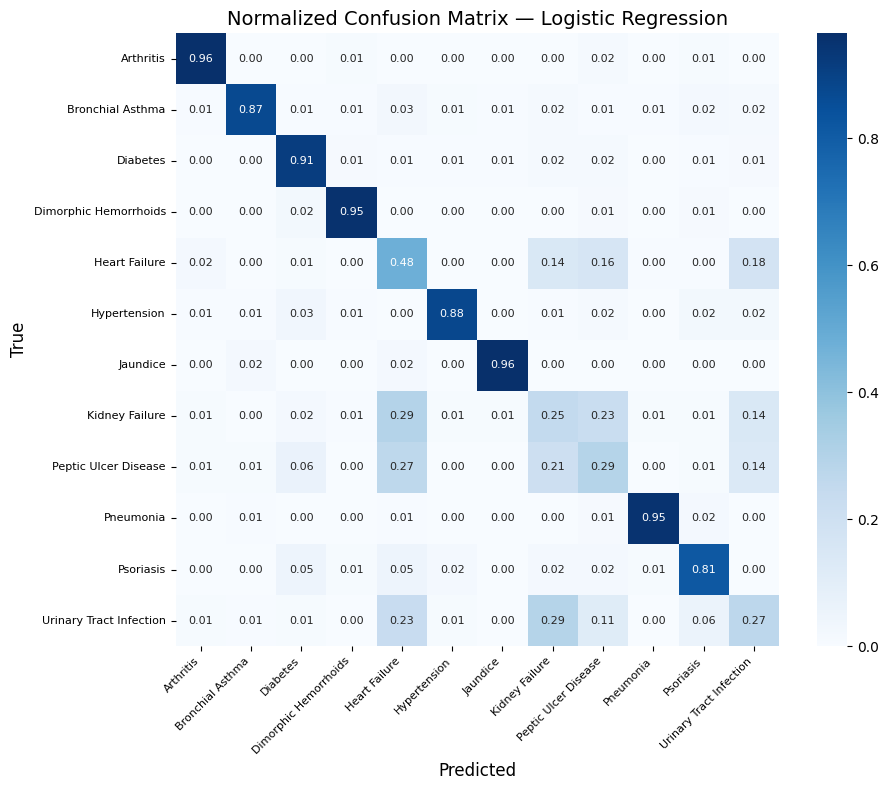

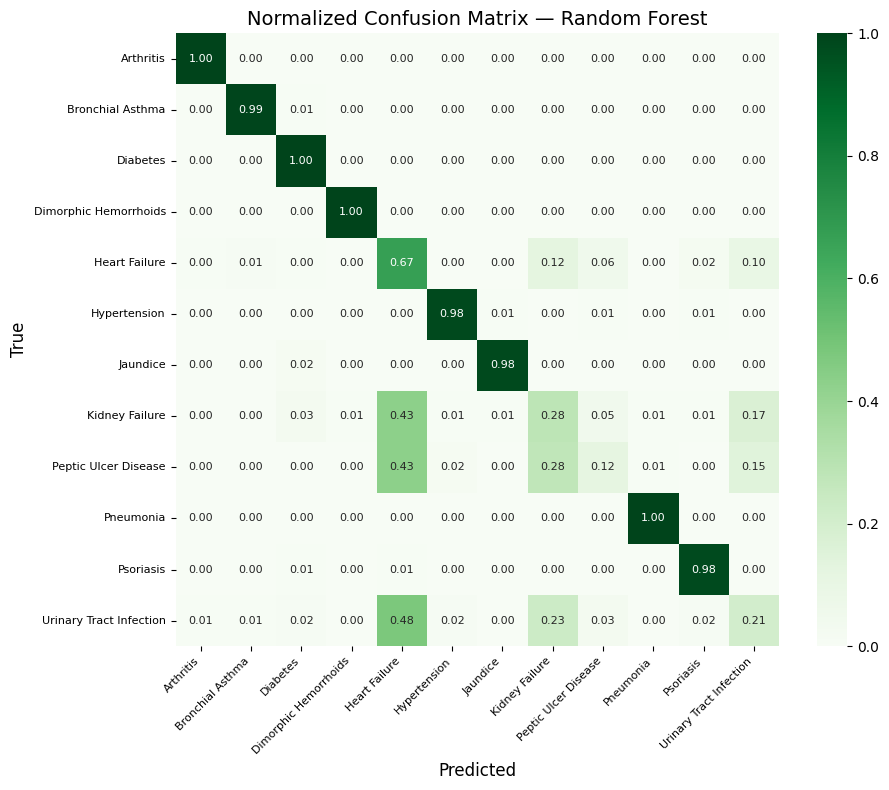

In [15]:
# ===10) CONFUSION MATRICES ===
def plot_cm(y_true, y_pred, labels, title, cmap):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(9.5, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 8})
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

class_names = list(le.classes_)
plot_cm(y_test, y_pred_lr, class_names, "Normalized Confusion Matrix — Logistic Regression", "Blues")
plot_cm(y_test, y_pred_rf, class_names, "Normalized Confusion Matrix — Random Forest", "Greens")